# Simulation of soft computing course's project
#### Author: Mahdi Tanbakuchi              SID: 9816408046


<b> First required libraries are imported to the workspace </b>

In [74]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from itertools import permutations

<i> Now lets define the model to generate our data which can be later used for evaluating the idea proposed in the abstract</i><br>
Below the Fr represents the acceptable frequnecies for the normal case while the Fw is representetive for the abnormal case. scale is used to generate samples from the frequency ranges randomly

In [102]:
Fr = np.linspace(0,10,30)
Fr = np.concatenate((Fr,np.linspace(15,30,30)))
Fw = np.linspace(10.1,14.9,30)
Fr = np.random.permutation(Fr)
Fw = np.random.permutation(Fw)
scale = np.linspace(1,100,100)
scale = np.random.permutation(scale)

Now parameter selection must be done in order to simulate the data for evaluation 

In [ ]:
N = 5 
trainsize = 1000
clr = 0.2
Fr = permutations(Fr,N)
Fw = permutations(Fw,N)
scale1=permutations(scale,N)
scale = np.random.permutation(scale)
scale2=permutations(scale,N)
posdatasize = trainsize*(1-clr)
negdatasize = trainsize*clr
posdata = list()
negdata = list()
for i in range(posdatasize):
    posdata.append(datagen(next(Fr),next(scale1)))
for i in range(negdatasize):
    negdata.append(datagen(next(Fw),next(scale2)))


Now that all the ingredients of the generator is made ready it is time to define the generator itself: <br>
The generator works as follows:
<list>
    <li> uses cosine function with the given frequency </li>
    <li> uses the wegith to superpose all the given frequencies </li>
</list>
The sampling frequency should also be given to the code (fs=256 hz by default)

In [82]:
def datagen(freq,coef,fs=256,duration=10):    
    t = np.arange(0,duration-1,1/fs)
    y = np.zeros(t.shape)
    if(np.linalg.norm(coef)!=1):
        coefnorm = coef/np.linalg.norm(coef)
    for i,j in zip(freq,coefnorm):
        y+=j*np.cos(2*np.pi*i*t)
    return y
        
    

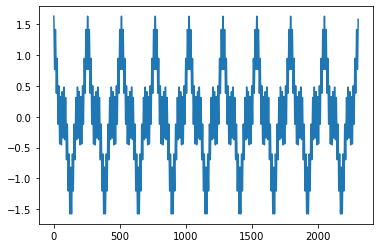

In [83]:
a = datagen([1,20,3],[2,1,1])
plt.plot(a)

In [97]:
a = np.arange(1,3,1)
b = np.arange(-10,-7,1)


In [98]:
aa = permutations(a,2)
bb = permutations(b,2)


In [99]:
for aaa,bbb in zip(aa,bb):
    print(aaa,"*",bbb)

(1, 2) * (-10, -9)
(2, 1) * (-10, -8)


In [90]:
h

(1, 4)